In [1]:
from tinydb import TinyDB, Query

In [79]:
db = TinyDB('/home/sergey.miller/research/data/example.db')
db.insert({'int': 1, 'data': {'a': 1, 'b':'2'}})
db.insert({'int': 2, 'data': {'c': 3, 'd':'4'}})

10

In [80]:
User = Query()
db.search(User.int == 2)

[{'data': {'d': '4', 'e': 4}, 'int': 2},
 {'data': {'d': '4', 'e': 4}, 'int': 2},
 {'data': {'c': 3, 'd': '4'}, 'int': 2}]

In [81]:
print(len(db))

10


<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=2, all_tables_documents_count=['_default=2']>

In [18]:
db.insert
db.update({'data': {'e': 4, 'd': '4'}, 'int': 2}, User.int == 2)

[6, 8]

In [19]:
db

<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=8, all_tables_documents_count=['_default=8']>

In [151]:
import numpy as np
import pandas as pd
import json
import time
import requests
import tqdm
import kalman

from os import listdir
from os.path import isfile, join


from IPython.display import clear_output
from collections import defaultdict

from tinydb import TinyDB, Query

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def parse_item(j):
    mac = j['notifications'][0]['apMacAddress']
    x = float(j['notifications'][0]['locationCoordinate']['x'])
    y = float(j['notifications'][0]['locationCoordinate']['y'])
    z = int(j['notifications'][0]['hierarchyDetails']['floor']['name'].replace('krs', '').replace(' ', '').replace('-', ''))
    event_id = j['notifications'][0]['eventId']
    latitude = float(j['notifications'][0]['geoCoordinate']['latitude'])
    longitude = float(j['notifications'][0]['geoCoordinate']['longitude'])
    timestamp = int(j['notifications'][0]['timestamp'])
    confidence = float(j['notifications'][0]['confidenceFactor'])
    return [
        x,  # 0
        y,  # 1
        z,  # 2
        latitude,  # 3
        longitude,  # 4
        timestamp,  # 5
        mac,  # 6
        event_id,  # 7
        confidence  # 8
    ]

In [242]:
def looks_bad(path):
    for i,p in enumerate(path[:-1]):
        if abs(p[3] - path[i+1][3]) > 0.00025 or abs(p[4] - path[i+1][4]) > 0.001:
            return True
    return False

def filter_f(x):
    return x[3] > 0 and 24.830 > x[4] > 0 and len(x[6]) > 0 and x[6] != 'NOT APPLICABLE'

In [32]:
def try_fix(line):
    line = line.strip()
    if line[-1] == ',':
        line = line[:-1]
    if line[0] == '{':
        line = '[\n' + line
    if line[-1] == '}':
        line = line + ']'
    if line[:4] == '[\n[\n':
        line = line[2:]
    return line.replace(']\n[\n', ',\n').replace(']\n{', ',\n{').replace('}{', '}\n{').replace('}\n{', '},\n{')

In [305]:
def update_prediction(table, mac, p, horizon=10 * 1000):
    p = np.array(p, dtype=np.object)
    sample =  p[:, np.array([3,4,2])]
    ts = p[:, 5].reshape(-1, 1)
    vel = (sample[1:] - sample[:-1]) / (ts[1:] - ts[:-1] + 1e-9) * (ts[1:] - ts[:-1] > 1e-9)
    X = np.concatenate([sample.reshape(-1), vel.reshape(-1)]).reshape(1, -1)
    Y_pred = predict_with_model(X)[0]
    
    

    if mac not in KALMAN:
        KALMAN[mac] = kalman.TimeSmoother(sample[-1], vel[-1], ts[-1])
    state = np.array(np.concatenate([sample[-1], vel[-1]]), dtype=float)
    KALMAN[mac].kalman_update(ts[-1], state, Y_pred)

    new_info = {'pred': ','.join(map(str,list(Y_pred))), 
                'for_ts': int(p[-1][5]) + horizon, 
                'mac': mac, 
                'kalman_mu': ','.join(map(str,list(KALMAN[mac].car_kalman.kalman.mu)))}
    q = Query()
    r = table.search(q.mac == mac)
    if len(r) == 0:
        table.insert(new_info)
    else:
        table.update(new_info, q.mac == mac)
    return (Y_pred[0], Y_pred[1], mac)

In [286]:
db = TinyDB('/home/sergey.miller/research/data/prod.db')
track_table = db.table('tracks')

In [325]:
db.purge_tables()

In [288]:
import pickle

In [100]:
with open('data/model_KNN_100_L1.pickle','rb') as f:
    models = pickle.load(f)

In [102]:
X_normalizer, Y_normalizer, model = models

In [106]:
def predict_with_model(x):
    return Y_normalizer.inverse_transform(model.predict(X_normalizer.transform(x)))

In [326]:
KALMAN = dict()

In [327]:
my_pos = [60.185469, 24.824695]

need mac  [(60.18557317349813, 24.82455965068471, '00:fc:ba:91:1c:80'), (60.185556150886406, 24.824553431088926, '00:fc:ba:91:1c:80'), (60.18557136422062, 24.824552594089166, '00:fc:ba:91:1c:80'), (60.185564781490065, 24.82457673150946, '00:fc:ba:91:1c:80'), (60.18545783123105, 24.824681658127414, '00:fc:ba:91:1c:80'), (60.185544149235426, 24.824554285599273, '00:fc:ba:91:1c:80'), (60.18557018997456, 24.824553319203314, '00:fc:ba:91:1c:80'), (60.185564781490065, 24.82457673150946, '00:fc:ba:91:1c:80'), (60.185451588547245, 24.824666555471918, '00:fc:ba:91:1c:80')]


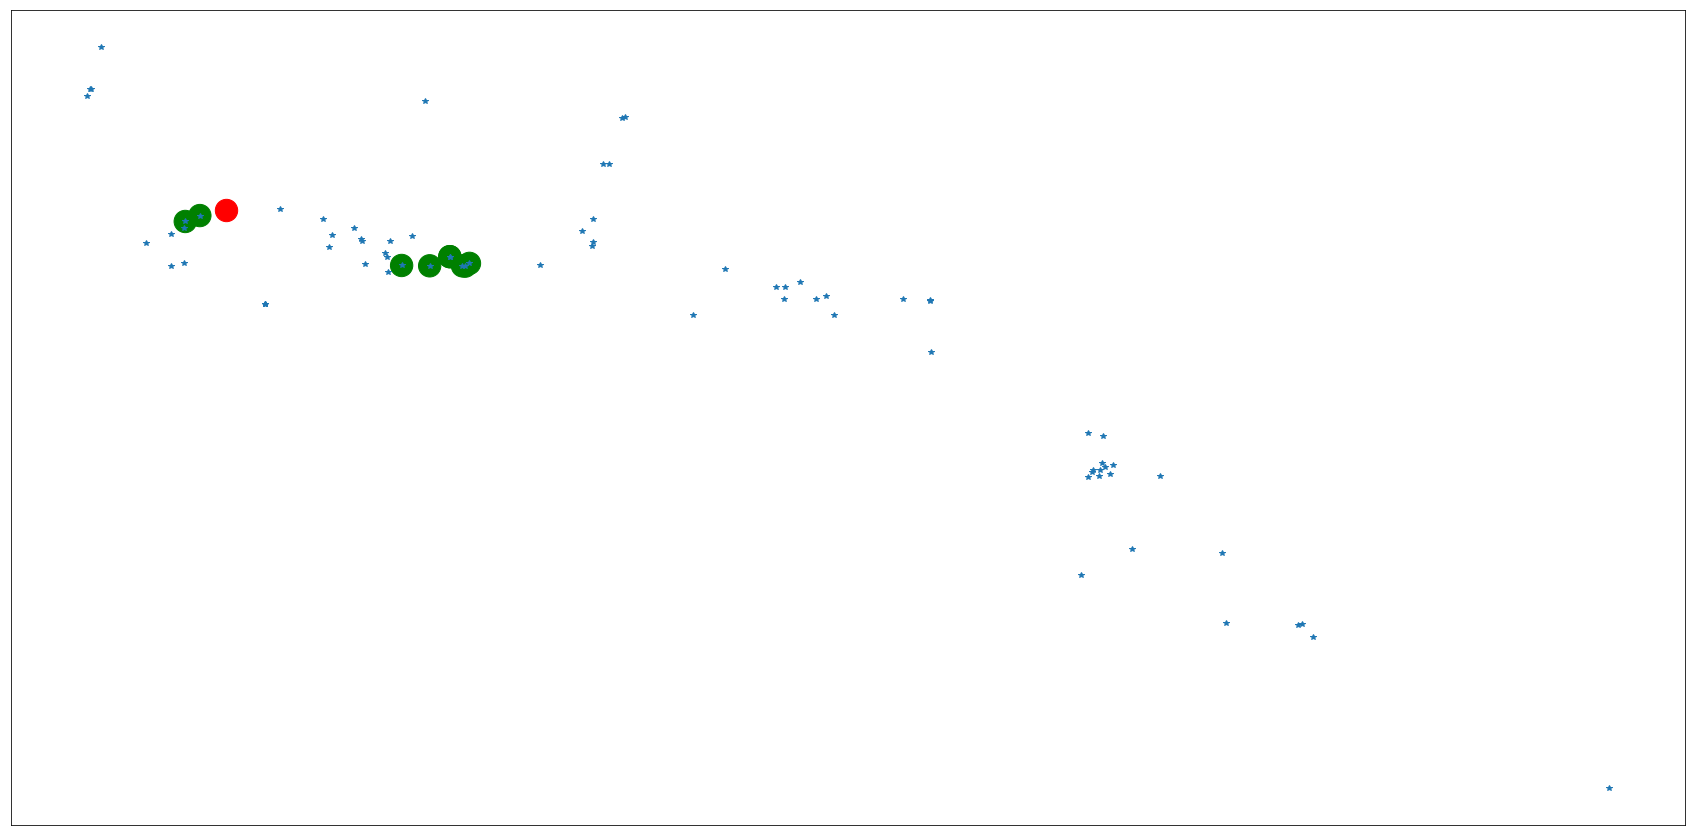

351
352


In [ ]:
paths = defaultdict(list)
ticks = 0
delta = 0.1
ticks = 0

preds = []

while True:
    ticks += 1
    print(ticks)
    time.sleep(delta)
    if ticks % (5) == 0 and len(preds) > 0:
#         preds = sorted(preds, key=lambda x: (x[0] - my_pos[0]) ** 2 + (x[1] - my_pos[1]) ** 2)[:50
        clear_output()
        plt.figure(figsize=(30,15))
#         for m in paths:
#             plt.plot([x[3] for x in paths[m]], [x[4] for x in paths[m]], '.-', alpha=0.5)
        plt.plot([x[0] for x in preds], [x[1] for x in preds], '*', alpha=1)
        plt.scatter([my_pos[0]], [my_pos[1]],s=[500],color='red')
        pos = [x for x in preds if x[2] in ['00:fc:ba:91:1c:80']]
        print('need mac ', pos)
        if len(pos) > 0:
            plt.scatter([x[0] for x in pos], [x[1] for x in pos],s=[500] * len(pos),color='green')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        preds = []

    try:
        r = requests.get("http://13.48.149.61:8000/notifycache.json",verify=False)
#         r = requests.get("http://13.48.149.61:8000/notify.json",verify=False)
        
        s = json.loads(try_fix(r.content.decode('utf-8')))
        items = np.array([parse_item(x) for x in s], dtype=np.object)
        for it in items:
            if filter_f(it):
                ts, mac = it[5], it[6]
                if mac in paths:
                    last_ts = paths[mac][-1][5]
                    paths[mac] = paths[mac][-3:]
                else:
                    last_ts = 0
                if ts - last_ts >= 10 * 1000:
                    paths[mac] = list()
                paths[mac].append(it)
                if len(paths[mac]) == 4:
                    next_pt = update_prediction(track_table, mac, paths[mac])
                    preds.append(next_pt)
    except Exception as e:
#         pass
        print(e)
#         l = r.content.decode('utf-8')
#         print(l)
#         print('*******************')
#         print(try_fix(l))
#         break

In [77]:
len(track_table)

0